### Augment the PythonPath so python can find necessary code.

In [4]:
import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('/home/andalman/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('/home/andalman/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('/home/andalman/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

### Import useful python packages

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import pandas as pd
import scipy
import skimage.io
import visualization_utils as vizutil
import seaborn as sns
from skimage.filters import gaussian_filter

In [6]:
import pandas as pd
from pandas import DataFrame

### Load the data

hbstim_imaging_utils provides a list of all the datasets and provides a helper class to make loading the data easy.

The data_sets are split into two conditions:  
'c': chr2 negative fish (n=4)  
'e': chr2 positive fish (n=6)  
  
all_data is a dictionary keyed by the condition.  
all_data[condition] contains a list of HbStim_Fish objects.

In [7]:
# import hbstim_imaging_utils as hbutils
import passivity_2p_imaging_utils as p2putils
# reload(hbutils)
reload(p2putils)
tmp_dir = '/tmp/'
# all_data = hbutils.get_all_datasets(tmp_dir=tmp_dir)
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

print 'c, n =', len(all_data['c'])
print 'e, n =', len(all_data['e'])

/home/tbenst/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


c, n = 8
e, n = 12


In [8]:
#Grab the first experimental fish
print('p2_fish')
f = all_data.e[1] 
print 'Num z-planes imaged:', f.num_zplanes
print 'Volume-Rate:', 1/np.diff(f.frame_st[:,0]).mean() #frame_st is #frames x #slices, we examine interval between imaging first slice
print 'Movement Times', f.forward_swim_times
print 'Shock times', f.shock_st

p2_fish
Num z-planes imaged: 6
Volume-Rate: 1.1111239123614585
Movement Times [  22.5944   23.6027   24.6611   27.0445   29.7863   30.5864   31.5697
   32.3114   35.2532   38.1283   41.1618   42.0035   43.6702   44.4286
   46.5537   48.0704   49.2871   51.7372   52.6039   54.3623   55.9791
   56.8958   58.7292   59.5125   61.5376   63.2627   65.2961   66.9712
   67.6546   69.463    71.3964   73.3048   74.9132   76.8299   78.7467
   80.9634   82.3468   84.4802   89.3888   90.8472   93.1306   95.0807
   97.4724   99.0308  103.6227  105.9061  107.5062  108.4479  111.673
  114.7398  117.0982  119.8067  121.3901  122.8318  125.9736  128.0154
  131.5572  133.4073  136.5741  140.5576  144.5077  146.3245  151.558
  157.8833  158.9     162.6251  164.7085  167.3003  171.8588  175.584
  178.6674  180.5342  184.3843  188.1262  199.5016  202.2101  204.8685
  215.794   224.711   228.8362  662.7373  663.7624  946.5073  989.9341
 1045.5447 1057.0535 1064.5622 1064.7289 1066.3539 1650.2113 1650.5279
 1

In [9]:
f = all_data.e[1] 
# print 'Num z-planes imaged:', f.num_zplanes
# print 'Number of stimulation trials:', f.numtrials
print 'Num z-planes imaged:', f.num_zplanes
print 'Volume-Rate:', 1/np.diff(f.frame_st[:,0]).mean() #frame_st is #frames x #slices, we examine interval between imaging first slice
print 'Movement Times', f.forward_swim_times
print 'Shock times', f.shock_st

Num z-planes imaged: 6
Volume-Rate: 1.1111239123614585
Movement Times [  22.5944   23.6027   24.6611   27.0445   29.7863   30.5864   31.5697
   32.3114   35.2532   38.1283   41.1618   42.0035   43.6702   44.4286
   46.5537   48.0704   49.2871   51.7372   52.6039   54.3623   55.9791
   56.8958   58.7292   59.5125   61.5376   63.2627   65.2961   66.9712
   67.6546   69.463    71.3964   73.3048   74.9132   76.8299   78.7467
   80.9634   82.3468   84.4802   89.3888   90.8472   93.1306   95.0807
   97.4724   99.0308  103.6227  105.9061  107.5062  108.4479  111.673
  114.7398  117.0982  119.8067  121.3901  122.8318  125.9736  128.0154
  131.5572  133.4073  136.5741  140.5576  144.5077  146.3245  151.558
  157.8833  158.9     162.6251  164.7085  167.3003  171.8588  175.584
  178.6674  180.5342  184.3843  188.1262  199.5016  202.2101  204.8685
  215.794   224.711   228.8362  662.7373  663.7624  946.5073  989.9341
 1045.5447 1057.0535 1064.5622 1064.7289 1066.3539 1650.2113 1650.5279
 1651.0446

The `get_roi_table` method returns a dataframe of all the rois for teh fish.  Each row of this table represents an ROI and specified the place the ROI is in, the pixels that are included in the ROI, the centroid of the ROI, and which brain regions the ROI is in.  

Note, this data is older and was processed by simply segmenting the anatomical images.  Thus the data is does not look as clean as data that is cleaned up and processed using CNMF, for example.

In [10]:
df = f.get_roi_table() #this can be slow to run the first time as data is loaded from files
df.head()

,fishid,z,zndx,roi_img_label,coords,centroid_x,centroid_y,area,solidity,eccentricity,...,in_l_tel,in_r_ctel,in_l_LHb,in_l_MHb,in_r_vthal,in_r_MHb,in_l_dthal,region,hemisphere,region_bilat
0,f01531,0,0,1,"[[1, 118], [1, 119], [1, 120], [1, 121], [1, 1...",1.933333,120.400000,15,0.937500,0.874444,...,False,False,False,False,False,False,False,other,w,other
1,f01531,0,1,2,"[[1, 126], [1, 127], [1, 128], [1, 129], [1, 1...",2.071429,127.642857,14,1.000000,0.698898,...,False,False,False,False,False,False,False,other,w,other
2,f01531,0,2,3,"[[0, 263], [1, 260], [1, 261], [1, 262], [1, 2...",2.000000,262.578947,19,0.826087,0.739813,...,False,False,False,False,False,False,False,other,w,other
3,f01531,0,3,4,"[[1, 292], [1, 293], [1, 294], [1, 295], [1, 2...",1.941176,294.352941,17,1.000000,0.875727,...,False,False,False,False,False,False,False,other,w,other
4,f01531,0,4,5,"[[1, 298], [1, 299], [1, 300], [1, 301], [1, 3...",1.933333,300.266667,15,0.937500,0.763716,...,False,False,False,False,False,False,False,other,w,other


#### 'get_signals_raw' returns a matrix containing the raw fluorescent signal associated with each ROI.  Each row of this matrix is associated with the corresponding row of the ROI table.  

Note, I only use the second half of the signal matrix, because the agarose had not fully hardened during the first of imaging which cause the fish to drift in z slightly.

In [11]:
M = f.get_signals_raw(z=None)
#M = hbutils.df_over_f(M)
print 'Num ROIs:', df.shape[0]
print 'Shape of signal matrix', M.shape

Num ROIs: 7421
Shape of signal matrix (7421, 3010)


There are also various methods for grabbing the raw imaging data:  
get_tif_as_vol  
get_tif_rasl

We can use this to visualize a few ROIs in particular plane/slice and brain region:

In [12]:
M.shape

(7421, 3010)

In [13]:
import statsmodels.tsa.stattools as stat
from scipy.stats import norm

/home/tbenst/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
def gcause_pval(X,lag=1):
    gc = stat.grangercausalitytests(X,lag, verbose=False)
    x = list(gc.values())[0]
    return x[0]["params_ftest"][1]

In [15]:
def moving_average(a, n=3) :
    ret = np.cumsum(a,0)
    ret[n:] = ret[n:] - ret[:-n]
    rm = ret[n - 1:] / n
    pad_start = np.full((n-1,rm.shape[1]), rm[0])
    return np.vstack([pad_start, rm])

def ewma(data,span):
    df = DataFrame(data)
    return df.ewm(span).mean().values

def df_f(x,ma_window=60,span=60):
    u = moving_average(x,ma_window)
    return ewma((x - u)/(u+1e-10), span)

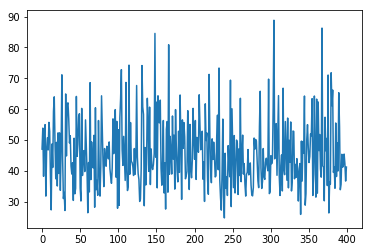

In [16]:
plt.plot(M[0,0:400])

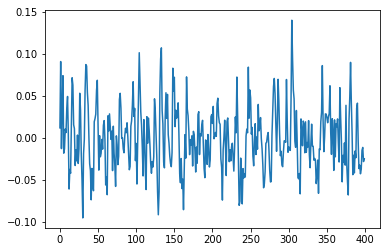

In [17]:
plt.plot(df_f(M[[0],0:400].T,6,6))

In [18]:
Mdf = df_f(M.T)

In [37]:
from scipy.stats import kurtosis, skew

In [39]:
kurtosis(M.reshape(-1))

9.541992024147977

In [40]:
skew(M.reshape(-1))

2.7747090638886402

In [36]:
kurtosis(Mdf.reshape(-1))

93.51318385536298

In [38]:
skew(Mdf.reshape(-1))

3.4911364500643427

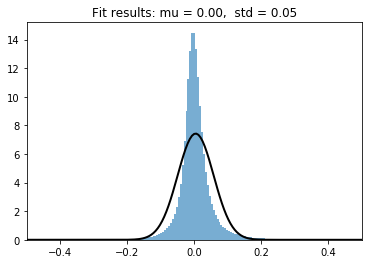

In [34]:
data = Mdf.reshape(-1)
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=1000, normed=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlim(-.5,.5)

plt.show()

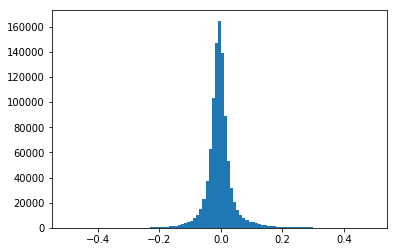

In [26]:
bins = np.arange(-.5,.5,0.01)
plt.hist(Mdf[0:1000,0:1000].reshape(-1),bins);

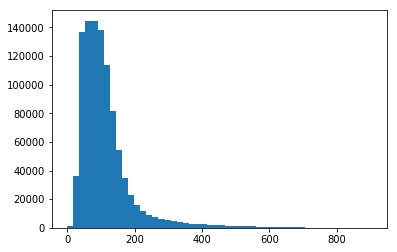

In [24]:
plt.hist(M[0:1000,0:1000].reshape(-1),50);

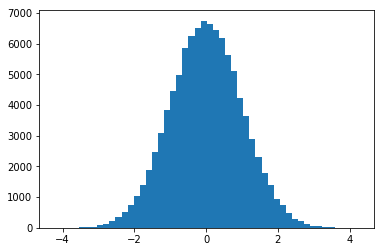

In [86]:
x = np.arange(0,100,5)
g = np.random.normal(0,1,100000)
y = [np.percentile(g,i) for i in x]
plt.hist(g,50);

In [80]:
np.min(g)

-4.120181162140761

In [16]:
gcause_pval(Mdf[:,0:2])

0.10152860247382722

niter = 10000
pvals = np.zeros(niter)
nroi = M.shape[0]
for n in range(niter):
    i, j = np.random.choice(nroi,2,False)
    pvals[n] = gcause_pval(Mdf[:,[i,j]])
plt.hist(pvals,100, density=True)
plt.title("Granger causality of random neuron pairs")
plt.xlabel("p val")
plt.ylabel("density")

# chord

In [17]:
ortho_regions = [u'in_r_cerebellum', u'in_l_cerebellum', u'in_l_vthal',
       u'in_l_tectum', u'in_l_raphe', u'in_r_hind', u'in_l_hind',
       u'in_l_dthal', u'in_r_tectum', u'in_r_LHb', u'in_r_dthal',
       u'in_r_raphe', u'in_r_tel',
       u'in_l_MHb', u'in_l_tel', u'in_r_MHb', u'in_l_LHb', u'in_r_vthal']

regions = df.columns[np.where([c in ortho_regions for c in df.columns])]

In [18]:
df[regions].sum(axis=0)

in_r_LHb       82
in_r_dthal     27
in_l_vthal     57
in_r_tel       32
in_l_raphe     53
in_r_raphe     40
in_l_tel       21
in_l_LHb       67
in_l_MHb      251
in_r_vthal     69
in_r_MHb      268
in_l_dthal     34
dtype: int64

In [19]:
neurons_in_one_region = np.where(df[regions].sum(axis=1)==1)[0]
neurons_in_Hb = np.array(df.query("in_r_LHb==1 | in_l_LHb==1").index)
neurons_in_Ra = np.array(df.query("in_r_raphe==1 | in_l_raphe==1").index)

In [20]:
nhab = len(neurons_in_Hb)
nra = len(neurons_in_Ra)

In [21]:
def get_region(row,regions):
    return np.where(row[regions])[0][0]

In [22]:
from joblib import Parallel, delayed

In [39]:
niter = 100000
nroi = neurons_in_one_region.shape[0]
def g_draw(n):
    np.random.seed(None)
    ii, jj = np.random.choice(nroi,2,False)
#     ii = np.random.choice(nra,1,False)[0]
    i, j = neurons_in_one_region[[ii,jj]]
#     i = neurons_in_Ra[ii]
    i_region = get_region(df.iloc[i],regions)
    j_region = get_region(df.iloc[j],regions)
    pval = gcause_pval(Mdf[:,[i,j]])
    return [i_region, j_region,pval]
    
granger_list = Parallel(n_jobs=24)(delayed(g_draw)(n) for n in range(niter))
granger = DataFrame(granger_list,columns=["from","to","pval"])

In [40]:
sig_idx = np.where(granger.pval < 0.05)[0]

In [41]:
len(sig_idx)

57919

In [42]:
import numpy as np
import pandas as pd
import holoviews as hv
from bokeh.sampledata.airport_routes import routes, airports

hv.extension('matplotlib')
%output fig='svg' size=300


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [43]:
links = granger.iloc[sig_idx].groupby(['from', 'to']).count().reset_index()

In [44]:
region_names = map(lambda x: x[3:], ortho_regions)
nodes = hv.Dataset(DataFrame(data={"index": np.arange(len(ortho_regions)), "name": region_names}),'index')
chord = hv.Chord((links,nodes))

In [45]:
%%opts Chord [edge_color_index='from' label_index='name' color_index='name']
# %%opts Chord (cmap='default_colors' edge_cmap='default_colors')
chord

:Chord   [from,to]   (pval)

# Archive

# Sparsity records
alpha 0.5: 100% sparse
alpha 1e-3: 99.9999% sparse

In [50]:
np.max(Mdf)

4.795954656584758

In [51]:
np.min(Mdf)

-0.9999999999942804

In [23]:
from datetime import datetime, timedelta
from __future__ import division

might need to use: http://foges.github.io/pogs/
currently ignoring intercept

In [ ]:
print("Estimated end: " + str(datetime.now() + timedelta(hours=2,minutes=24)))
dynamics_lasso = Lasso(alpha=1e-5,fit_intercept=False)
dynamics_lasso.fit(X,Y)
np.savez("dynamics_lasso_coef_alpha=1e-5_nointercept_uwindow=6_expwindow=6",dynamics_lasso.coef_)
percent_sparse = np.nonzero(dynamics_lasso.coef_)[0].shape[0]/np.prod(dynamics_lasso.coef_.shape)
print("Finished at: " + str(datetime.now()))
print("percent sparse: " + str(percent_sparse))

Estimated end: 2018-04-25 17:51:55.297179


/home/tbenst/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [24]:
coef = np.load("dynamics_lasso_coef_alpha=5e-4_nointercept_uwindow=6_expwindow=6.npz")['arr_0']

In [25]:
coef.shape

(18863, 18863)

In [26]:
np.nonzero(coef)[0].shape[0]

23878

In [28]:
1 - np.nonzero(coef)[0].shape[0]/np.prod(coef.shape)

0.9999328916720243

multi


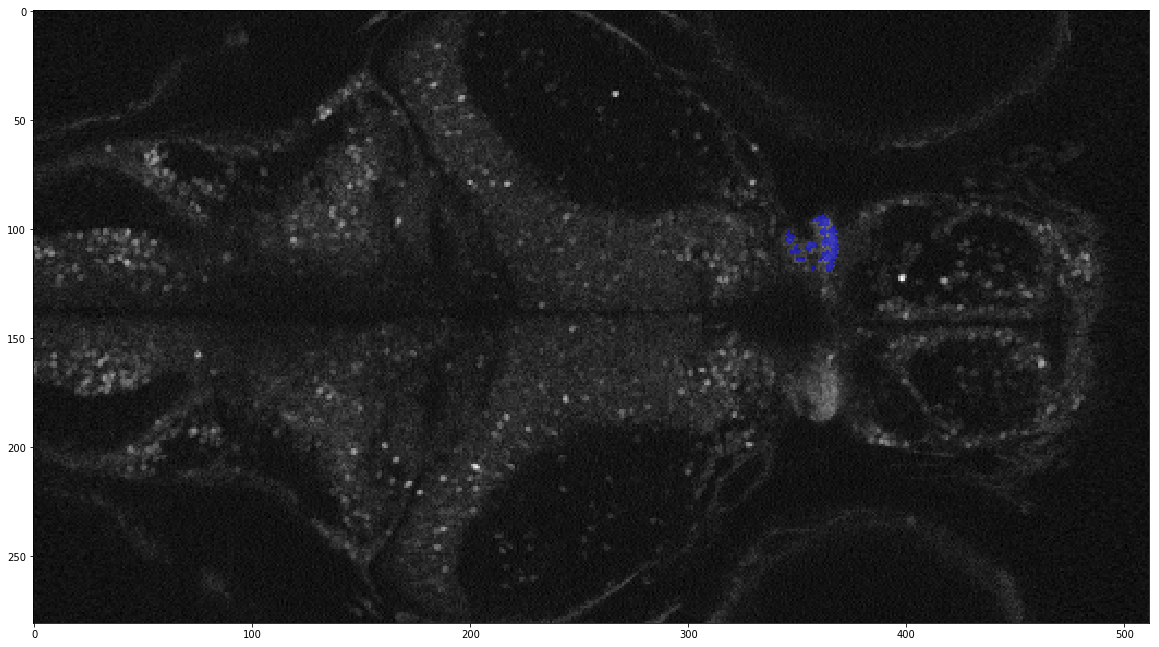

In [7]:
z=4

#Create a background image by averaging 200 frames and adjusting the gamma.
back_img = np.power(f.get_tif_as_vol(z,range(1000,1200)).mean(axis=2),.4)

#Select rois in raphe in this slices, and get their coordinates.
coords = df[(df.in_l_LHb) & (df.z==z)].coords

#Overlay the ROIs on the background image and display:
img = vizutil.overlay_coords(back_img, coords, [0,0,1], alpha=.5)
plt.figure(figsize=[20,20])
plt.imshow(img,interpolation='nearest')

During the imaging, 1P Scanning stimulation light is rotated between three locations:

In [8]:
print f.stim_locations

['lHb' 'forebrain' 'rHb']


In Chr2- fish none of these locations contained ChR2.  
  
In Chr2+ fish, the left LHb and the right LHb contained ChR2 positive cells.   
  
The forebrain never has ChR2 positive cells. It serves as control stimulation location.  It controls for the fact that the stimulation light is visible to the fish, and thus acts as a visual stimulus.

'num_frames_per_stim' indicates the number of volumes that are collected between stimulation locations:

In [9]:
print f.num_frames_per_stim

70


Lets call this number N.  Thus an experiment looks like:
    
Image N frames - Stim lHb - Image N frames - Stim forebrain - Image N frames - Stim rHb ...

This repeated is `numtrials` times.

In [10]:
print f.numtrials

15


The frame numbers of all frames immediately following stimulation at a particular location is therefore:

In [11]:
loc = 'lHb'
pos = (np.where(f.stim_locations == 'lHb')[0]+1) * f.num_frames_per_stim
ndx = np.arange(pos, M.shape[1], f.trialsize)
print ndx

[  70  280  490  700  910 1120 1330 1540 1750 1960 2170 2380 2590 2800
 3010]


### Response Statistics

For each ROI, I have computed whether the response to lHb (and rHb) stim is significantly different from the response to stimulation at the control location (forebrain).  

The response on each trial is taken as the change in flourescence between a baseline window and a response window.  In the example below, the baseline window is the 10 volumes prior to stimulation, and the response windows is the first 3 volumes following stimulation.

pvalues is a list of length # planes.  Each element is a list of the p-values of all the ROIs in that plane.

Note, because `get_norm_response_stats` can be slow to run, it caches results for particular baseline and response windows.  If you specify windows, I haven't run before it can be slow to run.

In [12]:
pvalues, rel_resps, abs_resps = f.get_norm_response_stats(stim_location='lHb', 
                                                          base_window_ndx=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1], 
                                                          resp_window_ndx=[0,1,2])

In [13]:
df_z = f.get_roi_table(z=0)
print df_z.shape
print pvalues[0].shape

(1579, 33)
(1579,)


In [14]:
np.arange(5)[:-1]

array([0, 1, 2, 3])